In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [13]:
def toBinary(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] == 255:
                image[i,j] = 1
            else :
                image[i,j] = 0
    return image

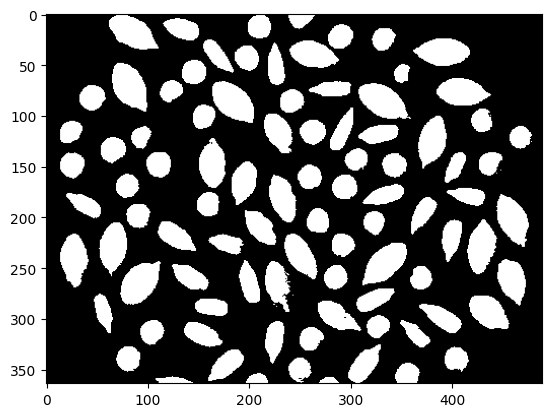

In [14]:
#Chargement Image

image = cv.imread("graine.jpg", cv.IMREAD_GRAYSCALE)
_, image = cv.threshold(image, 128, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

image = toBinary(image)

plt.imshow(image, cmap='gray')

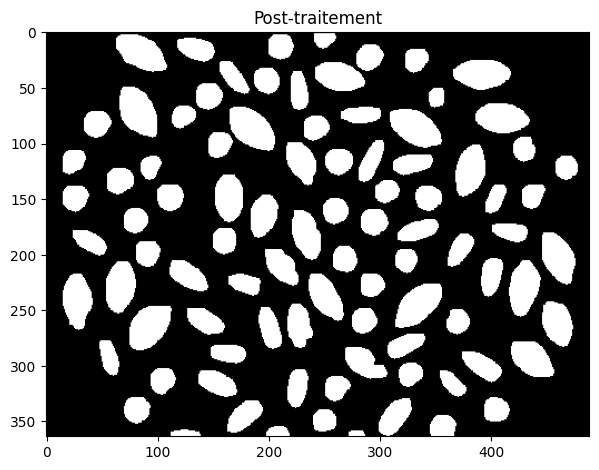

In [19]:
#Ouverture cercle
structuring_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (8,8))
opening = cv.morphologyEx(image, cv.MORPH_OPEN, structuring_element)

plt.imshow(opening, cmap= 'gray')
plt.title("Post-traitement")
plt.tight_layout()
plt.show()

In [16]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)
    plt.title("Composantes")

In [17]:
def imreconstruct(marker: np.ndarray, mask: np.ndarray, radius: int = 1):
    """Iteratively expand the markers white keeping them limited by the mask during each iteration.

    :param marker: Grayscale image where initial seed is white on black background.
    :param mask: Grayscale mask where the valid area is white on black background.
    :param radius Can be increased to improve expansion speed while causing decreased isolation from nearby areas.
    :returns A copy of the last expansion.
    Written By Semnodime.
    """
    kernel = np.ones(shape=(radius * 2 + 1,) * 2, dtype=np.uint8)
    while True:
        expanded = cv.dilate(src=marker, kernel=kernel)
        cv.bitwise_and(src1=expanded, src2=mask, dst=expanded)

        # Termination criterion: Expansion didn't change the image at all
        if (marker == expanded).all():
            return expanded
        marker = expanded

def comptage_cc(img):
    NCC1, _ = cv.connectedComponents(img)
    t = 1
    N = []
    cc_list = []

    while NCC1 > 1:
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (t,t))
        eroded = cv.erode(img, kernel)
        img = imreconstruct(eroded, img)

        NCC2, cc = cv.connectedComponents(img)
        cc_list.append((NCC2, cc))

        t += 1
        N.append(NCC1 - NCC2)
        NCC1 = NCC2
    return np.array(N), cc_list



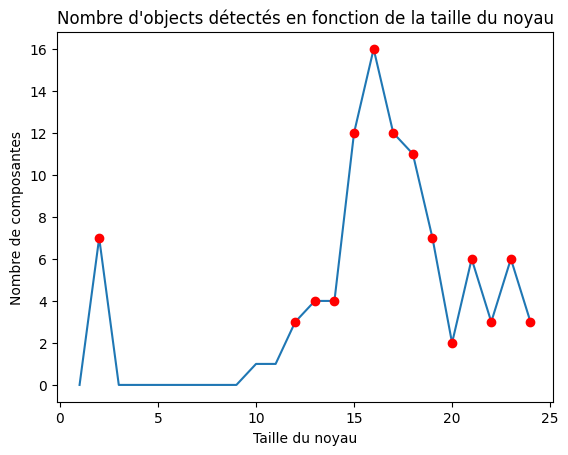

In [21]:
num_labels, labels_im = cv.connectedComponents(opening)

N, cc_list = comptage_cc(image)
threshold = 1

plt.plot(range(1, len(N)+1), N)
plt.plot(np.argwhere(N > threshold) + 1, N[N > threshold], "ro")

plt.xlabel("Taille du noyau")
plt.ylabel("Nombre de composantes")
plt.title("Nombre d'objects détectés en fonction de la taille du noyau")
plt.show()

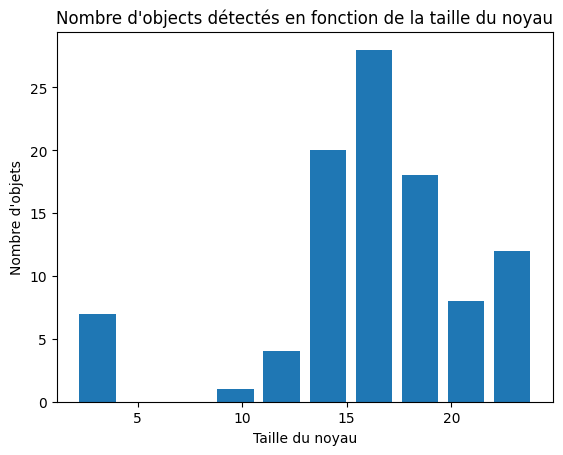

In [33]:
num_labels, labels_im = cv.connectedComponents(opening)

N, cc_list = comptage_cc(image)
threshold = 1

histogramme = []
for i in range(len(N)):
    for j in range(N[i]):
        histogramme.append(i+1)
plt.hist(histogramme, histtype='bar', rwidth=0.8)

plt.xlabel("Taille du noyau")
plt.ylabel("Nombre d'objets")
plt.title("Nombre d'objects détectés en fonction de la taille du noyau")
plt.show()